Experiments with different pretrained models VGG16 and RESNET50 with data augmentation with keras framework

Class imbalance is dealt with inverse proportion class weights 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

C:\Users\Ronan\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Hyperparameters
IMAGE_SIZE = 256
BATCH_SIZE = 8
CHANNELS= 3
ES_EPOCHS = 20 
CLASSES = 10
EPOCHS= 200

In [4]:
CLASS_NAMES = ["1989", "Acoustic", "Fearless", "Folkmore", "Lover", "Midnights", "Red", "Reputation", "Speak Now", "TTPD"]

In [5]:
# Directory with the images
test_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    seed=42,
    label_mode='int',
    validation_split=None,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 293 files belonging to 10 classes.


In [6]:
# Directory with the images
train_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 22450 files belonging to 10 classes.


In [7]:
# Directory with the images
val_dir = "C:/Users/Ronan/Documents/ML/Taylor_Swift_Projects/CNN/val"
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 302 files belonging to 10 classes.


In [8]:
print(f"""
    ----------------------------------
    Dataset split:
        - train split: {len(train_ds)}
        - val split: {len(val_ds)}
        - test split: {len(test_ds)}
    ----------------------------------
    """
)


    ----------------------------------
    Dataset split:
        - train split: 2807
        - val split: 38
        - test split: 37
    ----------------------------------
    


In [9]:
#Caching the dataset

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Normalize and rescale the images
#resize_and_rescale = tf.keras.Sequential([
#  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#  tf.keras.layers.Rescaling(1./255),
#])

In [11]:
# Proof that the images are rescaled
#normalized_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [12]:
# Import keras api 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomBrightness(factor=0.2)
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

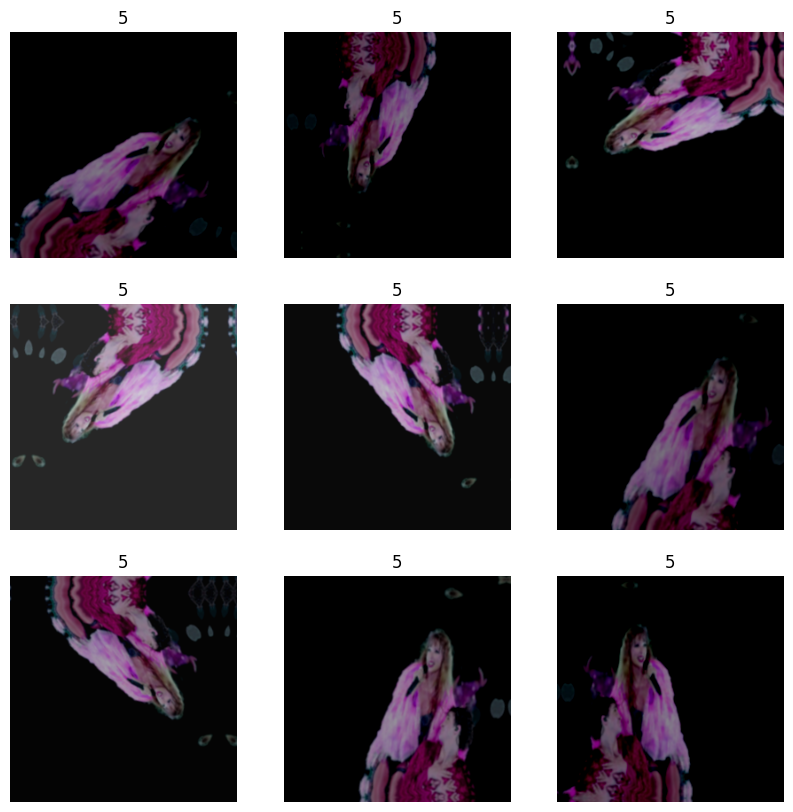

In [36]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [19]:
import os
import seaborn as sns
main_folder = 'augmented_train'

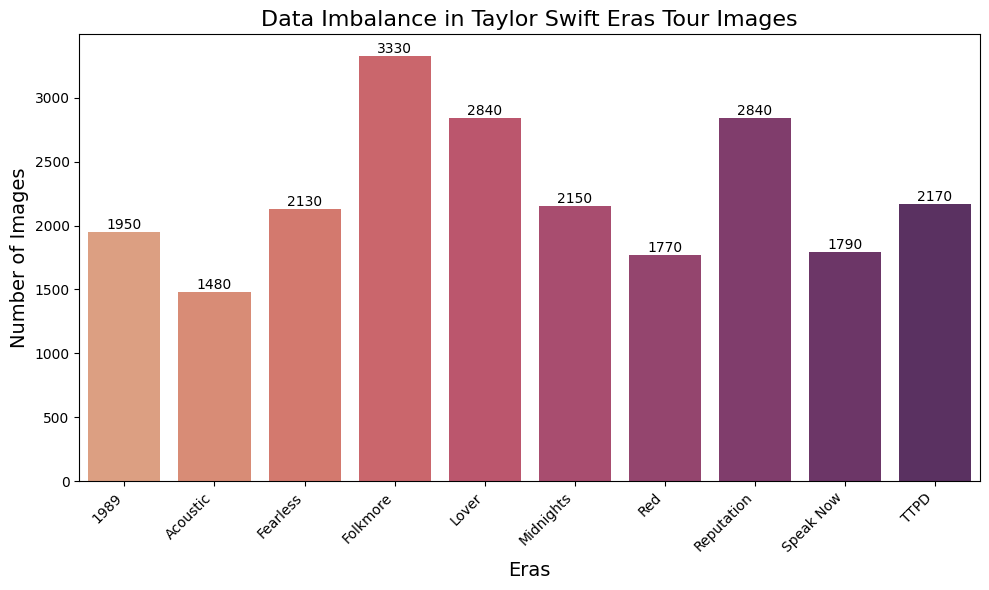

In [20]:
era_counts = {}

# Iterate through each subfolder (era)
for era_folder in os.listdir(main_folder):
    era_path = os.path.join(main_folder, era_folder)
    if os.path.isdir(era_path):
        # Count the number of images in the era folder
        era_counts[era_folder] = len([filename for filename in os.listdir(era_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Create a pandas DataFrame from the era_counts dictionary
import pandas as pd
df = pd.DataFrame({'Era': era_counts.keys(), 'Image Count': era_counts.values()})

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
ax = sns.barplot(x='Era', y='Image Count', data=df, palette='flare')  # Choose a color palette you like
for bar in range(len(ax.containers)):
    ax.bar_label(ax.containers[bar])
# Customize the plot
plt.title('Data Imbalance in Taylor Swift Eras Tour Images', fontsize=16)
plt.xlabel('Eras', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout for better spacing

# Display the plot
plt.show()

In [21]:
def get_weight_inverse_num_samples(num_of_classes, samples_per_classes, coeff=1):
    """
    Get the inverse number of samples for each class.
    Args:
        num_of_classes (int): Number of classes in the dataset.
        samples_per_classes (list): List of number of samples per class.
        power (int, optional): Power of the inverse number of samples. Defaults to 1.
    Returns:
        list: List of inverse number of samples for each class.
    """

    inverse_num_samples = []
    total_samples = sum(samples_per_classes)

    for i in range(num_of_classes):
        inverse_num_samples.append((total_samples / (num_of_classes * samples_per_classes[i])) * coeff)

    return inverse_num_samples

num_of_classes = 10
samples_per_classes = [era_counts['1989'], era_counts['Acoustic'], era_counts['Fearless'], era_counts['Folkmore'], era_counts['Lover'], era_counts['Midnights'], era_counts['Red'], era_counts['Reputation'], era_counts['Speak Now'], era_counts['TTPD']] 

weighted_classes = get_weight_inverse_num_samples(num_of_classes, samples_per_classes)


In [22]:
class_indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [23]:
weights = dict(zip(class_indexes, weighted_classes))

In [24]:
weights

{1: 1.1512820512820512,
 2: 1.5168918918918919,
 3: 1.0539906103286385,
 4: 0.6741741741741741,
 5: 0.7904929577464789,
 6: 1.044186046511628,
 7: 1.268361581920904,
 8: 0.7904929577464789,
 9: 1.2541899441340782,
 10: 1.0345622119815667}

Use pretrained model ResNet50 to experiment if we can have further improvements

In [25]:
conv_base = tf.keras.applications.ResNet50(
weights="imagenet",
include_top=False,
input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

Used pretrained model VGG16

In [26]:
#conv_base = tf.keras.applications.vgg16.VGG16(
#weights="imagenet",
#include_top=False,
#input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [27]:
for layer in conv_base.layers[:-8]:
    layer.trainable = False

In [ ]:
conv_base.summary()

In [29]:
from tensorflow.keras.regularizers import l2

In [31]:
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

#x = data_augmentation(inputs)

#x = resize_and_rescale(x)

x = tf.keras.applications.resnet.preprocess_input(inputs)
#x = tf.keras.applications.vgg16.preprocess_input(x)

# The output of the base model is taken as the input for the new model
x = conv_base(x)
# This layer averages the spatial dimensions (height and width) of the output from the previous layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a Dense layer with 512 units and 'relu' activation function to the model
x = tf.keras.layers.Dense(512, activation="relu")(x)
# This layer randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting
x = tf.keras.layers.Dropout(0.5)(x)
# This layer will output the probabilities for the 10 classes
outputs = tf.keras.layers.Dense(CLASSES, activation="softmax", kernel_regularizer=l2(0.001))(x)

#outputs = tf.keras.layers.Dense(CLASSES, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
from tensorflow.keras import callbacks

In [34]:
filepath="saved_models/all_VGG16_models/best_model_weighted_RESNET50_getty_aug.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
lr_plateau = callbacks.ReduceLROnPlateau(factor=0.8, monitor="val_accuracy", patience=5, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=ES_EPOCHS)
callbacks_list = [checkpoint, es, lr_plateau]
#callbacks_list = [checkpoint, es]

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    class_weight=weights
)

Epoch 1/200


1431/2807 ━━━━━━━━━━━━━━━━━━━━ 6:13 272ms/step - accuracy: 0.1926 - loss: 2.5231

KeyboardInterrupt: 

In [ ]:
filepath = "saved_models/all_VGG16_models/best_model_weighted_RESNET50_getty_aug.keras"
best_model = tf.keras.models.load_model(filepath)

In [ ]:
scores = best_model.predict(test_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

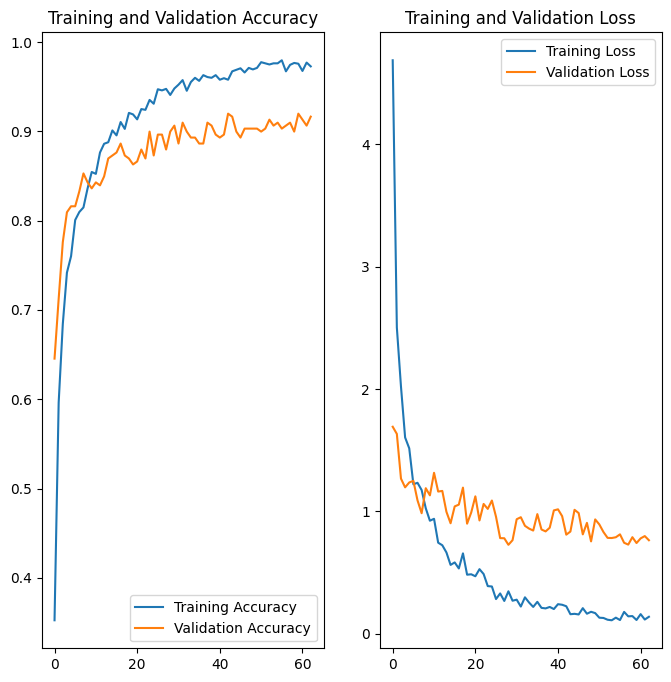

In [ ]:
EPOCHS = 63

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def create_list_y(dataset, model):
  y_true = []
  y_pred = []

  for x, y in dataset:
    y_true.append(y)
    y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
  y_pred = tf.concat(y_pred, axis=0)
  y_true = tf.concat(y_true, axis=0)

  return y_pred, y_true

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

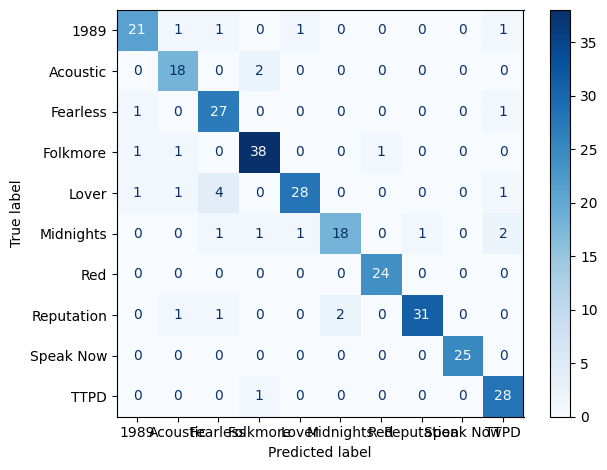

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred, y_true = create_list_y(test_ds, best_model)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)

disp.plot(cmap=plt.cm.Blues)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

        1989       0.88      0.84      0.86        25
    Acoustic       0.82      0.90      0.86        20
    Fearless       0.79      0.93      0.86        29
    Folkmore       0.90      0.93      0.92        41
       Lover       0.93      0.80      0.86        35
   Midnights       0.90      0.75      0.82        24
         Red       0.96      1.00      0.98        24
  Reputation       0.97      0.89      0.93        35
   Speak Now       1.00      1.00      1.00        25
        TTPD       0.85      0.97      0.90        29

    accuracy                           0.90       287
   macro avg       0.90      0.90      0.90       287
weighted avg       0.90      0.90      0.90       287



In [ ]:
#from io import BytesIO
#from PIL import Image

#def read_file_as_img(file_path)-> np.ndarray:
#    with open(file_path, 'rb') as f:
#        data = f.read()
#    image = np.array(Image.open(BytesIO(data)))

#    return image

In [ ]:
# Load the tensorflow model
#PROD_MODEL_PATH = "saved_models/all_VGG16_models/best_model_weighted_RESNET50.keras"

#PROD_MODEL = tf.keras.models.load_model(PROD_MODEL_PATH)

In [ ]:
#img = read_file_as_img("images/taylor-swift-eras-tour-032023-3-1-cab011d6ac7243e68b93d383134ad604.jpg")

# Resize the image to 256x256
#img = tf.image.resize(img, [256, 256]) 

# Predict the image classification
#img_batch = np.expand_dims(img, 0)
#predictions = PROD_MODEL.predict(img_batch)

#predicted_class = CLASS_NAMES[np.argmax(predictions[0])]

In [ ]:
#predicted_class